In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
  
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
print(tf.__version__)
from google.colab import drive
drive.mount('/content/drive')

2.0.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import matplotlib.pyplot as plt
import numpy as np

def plotLearning(x, scores, epsilons, filename, data, lines=None):

    textstr = data[0]
    textstr += '\nOptimizer: Adam\nLoss function: MSE\nActivation: elu'
    textstr += '\nAlpha = %.4f\nBatch size = %.0f\nMemory = %.0f\nEpisodes = %.0f'\
               '\nGamma = %.3f\nEpsilon start = 1\nEpsilon decay = %.4f\nEpsilon end = 0.001'\
               '\nAverage rewards=%.0f\nMost parked at: %.0f\nBest parking slot: '\
               '%.0f (according to rewards received (%.2f))\nFound after %.0f episodes\n'%(data[1],data[2],data[3],data[4],data[12],data[13],data[5],data[6],data[8],data[10],data[7])
    textstr += 'Random entry: '+str(data[11])+'\n'
    textstr += data[9]
    fig=plt.figure(figsize=(8.5, 6), dpi=100,)

    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Episode", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    plt.subplots_adjust(left=0.25)

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Reward', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    side_text = plt.figtext(1.05, 0, textstr, bbox=dict(facecolor='white'))
    fig.subplots_adjust(top=0.8)



    if lines is not None:
        for line in lines:
            plt.axvline(x=line)
    plt.savefig(filename,bbox_extra_artists=(side_text,), bbox_inches='tight')

In [0]:
#%%
import numpy as np
import numpy.random as rnd

import matplotlib.pylab as plt

import time
from datetime import datetime
import math

import networkx as nx
import csv

#%%
class Slot():
    """
    Parameters
    ----------
    slot_type: string
        values: 'P','D'
    """
    # This class is so far not used for the rest of the code, correct?
    def __init__(self, id_name, slot_type, slot_state):
        self.id_name = id_name
        self.slot_type = slot_type
        self.slot_state = slot_state


class Filling_Function_Parameters():
    def __init__(self, filling_function = 'uniform', uniform_distribution_p_value = 0.7):
        self.filling_function = filling_function
        self.uniform_distribution_p_value = uniform_distribution_p_value
    
    def getName(self):
        if (self.filling_function == 'uniform'):
            return 'U'+ "%.0f" % (self.uniform_distribution_p_value*100)



class Lane_Direction_Parameters():
    """
        directed_driving_lanes : boolean (default: False)
        Indicates if driving lanes are directed, if they are directed, lane_direction_function is obligatory
    """
    def __init__(self):
        self.directed_lanes = False
        self.lane_direction_function = "alternates"

#%%
class Parking_Lot():
    """ Base class for analyzing a directed graphs' bowtie structure values.
    A BowTieNetworkValues stores the number of nodes of each bowtie component
    and the percent of each component from the whole graph.
    Parameters
    ----------
    w : input integer (default: 10)
        Number of parking slots in dimension width
    l : input integer (default: 1)
        Number of parking slots in dimension length
    parking_lane_depth : input integer (default: 2)
        Single depth = 1, double depth 0 2
    single_depth_outer_lanes: boolean (default: True)
        Only relevant for double depth parking lanes.
        The first and last lane of the parking are only single depth parking slots
    lane_direction_paramenters :
        Object of
    filling_function_parameters :
        object of
    """

    def __init__(self, lane_direction_paramenters: Lane_Direction_Parameters, filling_function_parameters: Filling_Function_Parameters, nr_parking_slots_per_lane=10, nr_parking_lanes=1, parking_lane_depth=2, single_depth_outer_lanes=True, debug = False, draw_graph = False, show_summary = False):
        self.nr_parking_slots_per_lane = nr_parking_slots_per_lane
        self.nr_parking_lanes = nr_parking_lanes
        self.nr_parking_slots = nr_parking_slots_per_lane*nr_parking_lanes
        self.parking_lane_dept = parking_lane_depth
        self.single_depth_outer_lanes = single_depth_outer_lanes
        self.debug = debug
        # internal variables
        self.node_color_map = []
        self.nr_occupied_parking_slots = 0
        # helps define structure
        self.lane_direction_paramenters = lane_direction_paramenters
        # create grid
        self.slots = [0]*(nr_parking_lanes*nr_parking_slots_per_lane)
        self.nr_slots_per_lane = self.nr_parking_slots_per_lane+2
        self.nr_lanes_total =  self.get_number_of_lanes()
        self.nr_slots_total = self.nr_slots_per_lane*self.nr_lanes_total
        # self.printDebug('number_of_lanes='+str(self.nr_lanes_total))
        # self.printDebug('number_of_slots='+str(self.nr_slots_total))
        self.create_parking_geography()
        # update occupied places
        self.filling_function_parameters = filling_function_parameters
        self.fill_parking_slots()
        # set lane directions TODO
        #self.set_lane_directions()
        #self.export_to_pickle()

        if draw_graph:
            self.plot()

        if show_summary:
            print("nr_parking_slots", self.nr_parking_slots)
            print("nr_occupied_parking_slots = ", self.nr_occupied_parking_slots )
            pct_message = 'percent occupation = ' + f"({(self.nr_occupied_parking_slots/self.nr_parking_slots):.3g})"
            print(pct_message)
            # create occupancy status list including all parking spots
            print('Occupancy Status:')
            for slot_nr_in_graph in range(self.nr_slots_total):
                if self.g.nodes[slot_nr_in_graph]['slot_type'] == 'park':
                    print(f"{slot_nr_in_graph}: {self.g.nodes[slot_nr_in_graph]['occupation']}")


    def create_parking_geography(self):
        # width = number of parking slots + 1 driveway places on each side
        self.g = nx.grid_2d_graph(self.nr_lanes_total, self.nr_slots_per_lane)
#        forbidden = ((1,0),(1,1))
#        self.g.remove_edge(forbidden[0],forbidden[1])
        self.g = nx.convert_node_labels_to_integers(self.g)
        # depth is so far only implemented for parking lanes of depth 1
        if(self.parking_lane_dept==1):
            self.create_parking_single_depth()
        if(self.parking_lane_dept==2):
            self.create_parking_double_depth()


    def create_parking_single_depth(self):
        # only for single depth, we always start with drive path
        slot_nr_in_graph = -1
        for lane in range(self.nr_lanes_total):
            lane_nr = lane+1
            for slot_nr_in_lane in range(self.nr_slots_per_lane):
                slot_nr_in_graph += 1
                # the parking lanes
                if(lane_nr%2==0):
                    # the first and last slot are always drive slots
                    if((slot_nr_in_graph%self.nr_slots_per_lane == 0) or (slot_nr_in_graph%self.nr_slots_per_lane == self.nr_slots_per_lane-1)):
                        self.g.nodes[slot_nr_in_graph]['slot_type'] = 'drive'
                        self.node_color_map.append('grey')
                    else:
                        self.g.nodes[slot_nr_in_graph]['slot_type'] = 'park'
                        self.node_color_map.append('green')
                        self.g.nodes[slot_nr_in_graph]['occupation'] = 'vacant'
                else:
                        self.g.nodes[slot_nr_in_graph]['slot_type'] = 'drive'
                        self.node_color_map.append('grey')

    def create_parking_double_depth(self):
        # only for double depth, we always start with drive path
        slot_nr_in_graph = -1
        for lane in range(self.nr_lanes_total):
            lane_nr = lane+1
            for slot_nr_in_lane in range(self.nr_slots_per_lane):
                slot_nr_in_graph += 1
                # the parking lanes
                # first and last lane are drive lanes
                if(lane_nr==1) or (lane_nr == self.nr_lanes_total) or (slot_nr_in_graph%self.nr_slots_per_lane == self.nr_slots_per_lane-1) or (slot_nr_in_graph%self.nr_slots_per_lane == 0):
                    self.g.nodes[slot_nr_in_graph]['slot_type'] = 'drive'
                    self.node_color_map.append('grey')
                    # every third lane is drive lane
                elif((lane_nr-1)%3==0):
                    self.g.nodes[slot_nr_in_graph]['slot_type'] = 'drive'
                    self.node_color_map.append('grey')
                else:
                    self.g.nodes[slot_nr_in_graph]['slot_type'] = 'park'
                    self.node_color_map.append('green')
                    self.g.nodes[slot_nr_in_graph]['occupation'] = 'vacant'


    def printDebug(self, *val):
        if self.debug:
            """
            with open('file.txt', 'a') as f:
                print(str(datetime.today().strftime("%d-%m-%y %H %M %S")), 'DEBUG', list(val), file=f)
            """
            print(list(val))

    def get_number_of_lanes(self):
        """
        Basic function to find total number of aisles (parking and driving) based on the given number of
        parking aisles
        """
        # single depth parking lanes
        if(self.parking_lane_dept==1):
            return 2*self.nr_parking_lanes + 1
        if(self.parking_lane_dept==2):
            return 2*self.nr_parking_lanes - 1


    def set_lane_directions(self):
        if (self.lane_direction_paramenters.directed_lanes):
            if (self.lane_direction_paramenters.lane_direction_function == "alternates"):
                self.set_lane_direction_alternates()

    def set_lane_direction_alternates(self):
        G2 = nx.DiGraph(self.g)
        for edge in G2.edges():
            if edge != tuple(sorted(edge)):
                G2.remove_edge(*edge)

        nx.draw_spectral(G2, node_size=600, node_color='w')

    def plot(self):
        if(self.g.number_of_nodes() < 1000):
            self.g.nodes.data()
            pos = nx.spring_layout(self.g,iterations=1000)
            nx.draw(self.g, pos=pos,  node_color = self.node_color_map, with_labels=True)
            plt.savefig('/content/drive/My Drive/DQN/'+timestr+'_parking_lot.png', format="PNG")
        else:
            print("Graph is too large to be drawn")

    def fill_parking_slots(self):
        if self.filling_function_parameters.filling_function == 'uniform':
            return self.fill_parking_uniform()
        # TODO binomial distribution around the middle so it goes to the end of the parking
        # TODO other distribution where closer to the walking entry is full
        # TODO other distribution where closer to the car entry and to the walking entry is full

    def fill_parking_uniform(self):
        for i in range(self.nr_slots_total):
            if(self.g.nodes[i]['slot_type'] == 'park'):
                rn = rnd.rand()
                if (rn < self.filling_function_parameters.uniform_distribution_p_value):
                    self.node_color_map[i]='red'
                    self.g.nodes[i]['occupation'] = 'taken'
                    # so far only visual indication if parking spot is occupied (red)
                    # otherwise we only have visual indication and know number of occupied spots only on parking lot level
                    self.nr_occupied_parking_slots += 1

    def export_parking_lot_data(self):
        """
        Saves parking lot into a csv file
        """
        data = []
        for s in self.g.nodes:
            msg = s + ';'
            data.append(msg)

        with open('parking_lot.csv', 'wb') as f:
            writer = csv.writer(f)
            writer.writerows(data)

    def export_to_pickle(self):
        nx.write_gpickle(self.g,'parking_lot_big.gpl')

    def get_env(self):
        return self.g


In [0]:
#%%
import numpy as np
import collections
import networkx as nx
import matplotlib.pylab as plt

import os



#%%
class Reward_Parameters():
    def __init__(self):
        self.PARK_CRASH_REWARD = -200
        self.WALL_CRASH_REWARD = -200
        self.TIME_REWARD = -1
        self.BACKWARD_REWARD = -40
        self.STUCK_REWARD = -30
        self.PARKING_REWARD = 100
        self.DRIVEWAY_PARKING_REWARD = -100



# %%
class Park_Finder_Agent():
    def __init__(self, reward_parameters: Reward_Parameters, parking_environment: Parking_Lot):
        self.parking_lot = parking_environment.get_env()
        print(self.parking_lot)
        self.m = self.get_parking_lot_width()
        self.n = self.get_parking_lot_length()
        # 1 = UP, 2 = Down, 3 = Left, 4 = Right, 5 = Park
        self.actionSpace = {1: -self.m, 2: self.m, 3: -1, 4: 1, 5: 0}
        self.possibleActions = [1, 2, 3, 4, 5]
        self.taken_list = []
        self.vacant_list = []
        self.drive_list = []
        for i in range(len(self.parking_lot.nodes)):
            if len(self.parking_lot.nodes[i]) == 2:
                if self.parking_lot.nodes[i]['occupation'] == 'taken':
                    self.taken_list.append(i)
                elif self.parking_lot.nodes[i]['occupation'] == 'vacant':
                    self.vacant_list.append(i)
            else:
                self.drive_list.append(i)
        self.stateSpace = self.drive_list + self.vacant_list
        self.stateSpacePlus = self.drive_list + self.vacant_list + self.taken_list
        self.agentPosition = 0
        self.grid = self.parkingLotToArray()
        self.reward_parameters = reward_parameters
        
        
    def get_parking_lot_width(self):
        # gives back the number of rows of the complete parking lot including driveways.
        connection_list = []
        for pair in self.parking_lot.edges:
            connection_list.append(pair[0])
        single_connection_list = [item for item, count in collections.Counter(connection_list).items() if count == 1]
        return single_connection_list[1]-single_connection_list[0]

    def get_parking_lot_length(self):
        return int(len(self.parking_lot.nodes)/self.get_parking_lot_width())
     
    def parkingLotToArray(self):
        parking_lot_indices = np.array_split(self.parking_lot.nodes, self.m)
        grid = np.zeros((self.m,self.n))
        for i in range(0,self.m):
            for k in range(0,self.n):
                if self.parking_lot.nodes[parking_lot_indices[i][k]]['slot_type'] == 'drive':
                    grid[i][k] = 1
                if self.parking_lot.nodes[parking_lot_indices[i][k]]['slot_type'] == 'park' and self.parking_lot.nodes[parking_lot_indices[i][k]]['occupation'] == 'vacant':
                    grid[i][k] = 2
                if self.parking_lot.nodes[parking_lot_indices[i][k]]['slot_type'] == 'park' and self.parking_lot.nodes[parking_lot_indices[i][k]]['occupation'] == 'taken':
                    grid[i][k] = 0
        return grid
                
                
    def isTerminalState(self, state, action):
        return state in self.vacant_list and action == 5
        # return state in self.stateSpacePlus and state not in self.stateSpace
    
    def getElementRowAndColumn(self, position):
        x = position // self.m
        y = position % self.n
        return x, y

    def getAgentRowAndColumn(self):
        x = self.agentPosition // self.m
        y = self.agentPosition % self.n
        return x, y
    
    
    def setState(self, state):
        # where agent was, make it driveway again
        x, y = self.getAgentRowAndColumn()
        self.grid[x][y] = 1
        # where agent is, make square
        self.agentPosition = state
        x, y = self.getAgentRowAndColumn()
        self.grid[x][y] = 3
        
    def getReward(self, actualState, resultingState, action):
        # reward of -1 for wasting time and driving around
        if resultingState in self.drive_list:
            if resultingState < actualState and action in [1,2,3,4]:
                return self.reward_parameters.BACKWARD_REWARD
            if resultingState == actualState and action == 5:
                return self.reward_parameters.DRIVEWAY_PARKING_REWARD
            else:
                return self.reward_parameters.TIME_REWARD


        # reward of -300 of crashing in a parked car
        if resultingState in self.taken_list:
            return self.reward_parameters.PARK_CRASH_REWARD
        if actualState in self.taken_list:
            if action == 5:
                return 10 * self.reward_parameters.PARK_CRASH_REWARD
            else:
                return 5 * self.reward_parameters.PARK_CRASH_REWARD

        if actualState in self.vacant_list:
            if actualState == resultingState:
                if resultingState != max(self.vacant_list) and action == 5:
                    disc_reward = self.reward_parameters.PARKING_REWARD / ((nx.shortest_path_length(self.parking_lot,
                                                                                             source=self.agentPosition,
                                                                                             target=max(self.drive_list))) * 2)
                    return disc_reward
                if resultingState == max(self.vacant_list) and action == 5:
                    return self.reward_parameters.PARKING_REWARD
                # when driving over an empty parking slot to reach a better empty parking slot
            if resultingState != actualState and resultingState in self.vacant_list and action == 5:
                disc_reward = self.reward_parameters.PARKING_REWARD / ((nx.shortest_path_length(self.parking_lot,
                                                                                                source=self.agentPosition,
                                                                                                target=max(self.drive_list))) * 2)
                return disc_reward
            else:
                return self.reward_parameters.TIME_REWARD

        if actualState in self.drive_list and resultingState in self.vacant_list:
            return self.reward_parameters.TIME_REWARD

        if self.offGridMove(resultingState,actualState):
            return self.reward_parameters.WALL_CRASH_REWARD

        else:
            return 0

        
        
    def step(self, action):
        # agentX, agentY = self.getAgentRowAndColumn()
        resultingState = self.agentPosition + self.actionSpace[action]
        reward = self.getReward(self.agentPosition,resultingState, action)
        if reward == 0:
            print("something went wrong with the reward.. {} -> {}, action: {}".format(self.agentPosition,resultingState,action))
        else:
            reward = round(reward, 3)
        if not self.offGridMove(resultingState, self.agentPosition):
            self.setState(resultingState)
            # self.agentPosition = resultingState
            return resultingState, reward, self.isTerminalState(resultingState, action), None
        else:
            return self.agentPosition, reward, self.isTerminalState(self.agentPosition, action), None


    def offGridMove(self, newState, oldState):
        # if we move into a row not in the grid
        if newState not in self.stateSpacePlus:
            return True
        # if we're trying to wrap around to next row
        elif oldState % self.m == 0 and newState  % self.m == self.m - 1:
            return True
        elif oldState % self.m == self.m - 1 and newState % self.m == 0:
            return True
        else:
            return False

        
    def renderToFile(self):
        H = self.grid
        plt.imshow(H)
        plt.show()


    def reset(self):
        self.agentPosition = 0
        self.grid = self.parkingLotToArray()
        return self.agentPosition
    
    def actionSpaceSample(self):
        return np.random.choice(self.possibleActions)

In [0]:
# %%
import numpy as np
import collections
import networkx as nx
import matplotlib.pylab as plt
import random

import os




# %%

class Reward_Parameters():
    def __init__(self):
        self.PARK_CRASH_REWARD = -2
        self.WALL_CRASH_REWARD = -2
        self.TIME_REWARD = -0.25
        self.BACKWARD_REWARD = -1
        self.STUCK_REWARD = -1
        self.PARKING_REWARD = 6
        self.DRIVEWAY_PARKING_REWARD = -2


# %%
class NN_Park_Finder_Agent():
    def __init__(self, reward_parameters: Reward_Parameters, parking_environment: Parking_Lot):
        self.parking_lot = parking_environment.get_env()
        print(self.parking_lot)
        self.m = self.get_parking_lot_width()
        self.n = self.get_parking_lot_length()
        # 1 = UP, 2 = Down, 3 = Left, 4 = Right, 5 = Park
        self.actionSpace = {1: -self.m, 2: self.m, 3: -1, 4: 1, 5: 0}
        self.actionNames = {1: 'up', 2: 'down', 3: 'left', 4: 'right', 5: 'park'}
        self.possibleActions = [1, 2, 3, 4, 5]
        self.taken_list = []
        self.vacant_list = []
        self.drive_list = []
        for i in range(len(self.parking_lot.nodes)):
            if len(self.parking_lot.nodes[i]) == 2:
                if self.parking_lot.nodes[i]['occupation'] == 'taken':
                    self.taken_list.append(i)
                elif self.parking_lot.nodes[i]['occupation'] == 'vacant':
                    self.vacant_list.append(i)
            else:
                self.drive_list.append(i)
        self.stateSpace = self.drive_list + self.vacant_list
        self.stateSpacePlus = self.drive_list + self.vacant_list + self.taken_list
        self.agentPosition = 0
        self.grid = self.parkingLotToArray()
        self.reward_parameters = reward_parameters

    def get_parking_lot_width(self):
        # gives back the number of rows of the complete parking lot including driveways.
        connection_list = []
        for pair in self.parking_lot.edges:
            connection_list.append(pair[0])
        single_connection_list = [item for item, count in collections.Counter(connection_list).items() if count == 1]
        return single_connection_list[1] - single_connection_list[0]

    def get_parking_lot_length(self):
        return int(len(self.parking_lot.nodes) / self.get_parking_lot_width())

    def parkingLotToArray(self):
        parking_lot_indices = np.array_split(self.parking_lot.nodes, self.m)
        grid = np.zeros((self.m, self.n))
        for i in range(0, self.m):
            for k in range(0, self.n):
                if self.parking_lot.nodes[parking_lot_indices[i][k]]['slot_type'] == 'drive':
                    grid[i][k] = 1
                if self.parking_lot.nodes[parking_lot_indices[i][k]]['slot_type'] == 'park' and \
                        self.parking_lot.nodes[parking_lot_indices[i][k]]['occupation'] == 'vacant':
                    grid[i][k] = 2
                if self.parking_lot.nodes[parking_lot_indices[i][k]]['slot_type'] == 'park' and \
                        self.parking_lot.nodes[parking_lot_indices[i][k]]['occupation'] == 'taken':
                    grid[i][k] = 0
        return grid

    def isTerminalState(self, state, action):
        return state in self.vacant_list and action == 5
        #return action == 5
        # return state in self.stateSpacePlus and state not in self.stateSpace

    def getElementRowAndColumn(self, position):
        x = position // self.m
        y = position % self.n
        return x, y

    def getAgentRowAndColumn(self):
        x = self.agentPosition // self.m
        y = self.agentPosition % self.n
        return x, y

    def setState(self, state):
        # where agent was, make it driveway again
        x, y = self.getAgentRowAndColumn()
        self.grid[x][y] = 1
        # where agent is, make square
        self.agentPosition = state
        x, y = self.getAgentRowAndColumn()
        self.grid[x][y] = 3

    def getReward(self, actualState, resultingState, action):
        # reward of -1 for wasting time and driving around
        if resultingState in self.drive_list:
            if resultingState < actualState and action in [1, 2, 3, 4]:
              if actualState in [6,42]:
                return -0.1
              if actualState == 48:
                return 0.25
              else:
                return self.reward_parameters.BACKWARD_REWARD
            if resultingState == actualState and action == 5:
                return self.reward_parameters.DRIVEWAY_PARKING_REWARD
            else:
                return self.reward_parameters.TIME_REWARD

        # reward of -300 of crashing in a parked car
        if resultingState in self.taken_list:
            return self.reward_parameters.PARK_CRASH_REWARD
        if actualState in self.taken_list:
            if action == 5:
                return self.reward_parameters.PARK_CRASH_REWARD
            else:
                return self.reward_parameters.PARK_CRASH_REWARD

        if actualState in self.vacant_list:
            if actualState == resultingState:
                if resultingState != max(self.vacant_list) and action == 5:
                    disc_reward = self.reward_parameters.PARKING_REWARD / ((nx.shortest_path_length(self.parking_lot,
                                                                                                    source=self.agentPosition,
                                                                                                    target=max(
                                                                                                        self.drive_list))) * 2)
                    return disc_reward
                if resultingState == max(self.vacant_list) and action == 5:
                    return self.reward_parameters.PARKING_REWARD
                # when driving over an empty parking slot to reach a better empty parking slot
            if resultingState != actualState and resultingState in self.vacant_list and action == 5:
                disc_reward = self.reward_parameters.PARKING_REWARD / ((nx.shortest_path_length(self.parking_lot,
                                                                                                source=self.agentPosition,
                                                                                                target=max(
                                                                                                    self.drive_list))) * 2)
                return disc_reward
            else:
                return self.reward_parameters.TIME_REWARD

        if actualState in self.drive_list and resultingState in self.vacant_list:
            return self.reward_parameters.TIME_REWARD

        if self.offGridMove(resultingState, actualState):
            return self.reward_parameters.WALL_CRASH_REWARD

        else:
            return 0

    def step(self, action):
        # agentX, agentY = self.getAgentRowAndColumn()
        resultingState = self.agentPosition + self.actionSpace[action]

        reward = self.getReward(self.agentPosition, resultingState, action)
        if reward == 0:
            print(
                "something went wrong with the reward.. {} -> {}, action: {}".format(self.agentPosition, resultingState,
                                                                                     action))
        else:
            reward = round(reward, 3)
        if not self.offGridMove(resultingState, self.agentPosition):
            self.setState(resultingState)
            return self.get_observation(resultingState), reward, self.isTerminalState(resultingState, action), None
        else:
            return self.get_observation(self.agentPosition), reward, self.isTerminalState(self.agentPosition, action), None

    def get_observation(self, position):
        left = position + self.actionSpace[3]
        right = position + self.actionSpace[4]
        up = position + self.actionSpace[1]
        down = position + self.actionSpace[2]
        park = position + self.actionSpace[5]
        observations = [up, down, left, right, park]
        for i in range(len(observations)):
          if self.offGridMove(observations[i],position):
            observations[i] = -48
        return np.array(observations)


    def drive_parking(self, new_state):
        if new_state in self.drive_list:
          return True

    def offGridMove(self, newState, oldState):
        # if we move into a row not in the grid
        if newState not in self.stateSpacePlus:
            return True
        # if we're trying to wrap around to next row
        elif oldState % self.m == 0 and newState % self.m == self.m - 1:
            return True
        elif oldState % self.m == self.m - 1 and newState % self.m == 0:
            return True
        else:
            return False

    def renderToFile(self):
        H = self.grid
        plt.imshow(H)
        plt.show()

    def reset(self, rand=False):
        if rand:
          self.agentPosition = random.choice(self.drive_list+self.vacant_list)
        else:
          self.agentPosition = 0
        self.grid = self.parkingLotToArray()
        return self.get_observation(self.agentPosition)

    def actionSpaceSample(self):
        return np.random.choice(self.possibleActions)

In [0]:
from tensorflow.python.keras.layers import Dense, Activation, Conv1D, Flatten
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras import losses
import numpy as np
import os
import tensorflow as tf

tpu = False
try:
    device_name = os.environ['COLAB_TPU_ADDR']
    TPU_ADDRESS = 'grpc://' + device_name
    print('Found TPU')
    tpu = True
except KeyError:
    print('TPU not found')


class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.short_model_summary = ""

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
            #print("action memory: {}, action: {}, actions action: {}".format(self.action_memory,action,actions[action]))
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1-done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential([
                Dense(fc1_dims, input_shape=(input_dims,)),
                Activation('elu'),
                #Dense(fc2_dims),
                #Activation('elu'),
                Dense(fc2_dims),
                Activation('elu'),
                Dense(n_actions)])

    model.compile(optimizer=Adam(lr=lr), loss='mse',target_tensors=None)
    model.summary()
    return model

def build_double_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
  input_shape = [input_dims]
  n_outputs = n_actions

  model = Sequential([
      Dense(fc1_dims, activation= "relu", input_shape= input_shape),
      Dense(fc2_dims, activation="relu"),
      Dense(fc2_dims, activation="relu"),
      Dense(n_outputs)
  ])
  model.summary()
  return model

def build_conv_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=8, strides=4, activation='relu',
                     input_shape=(input_dims,), data_format='channels_first'))
    model.add(Conv1D(filters=64, kernel_size=4, strides=2, activation='relu',
                     data_format='channels_first'))
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, activation='relu',
                     data_format='channels_first'))
    model.add(Flatten())
    model.add(Dense(fc1_dims, activation='relu'))
    model.add(Dense(n_actions))

    model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error')

    return model

def build_dueling_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
  K = tf.keras.backend
  input_states = tf.keras.layers.Input(shape=[5])
  hidden1 = Dense(fc1_dims, activation='elu')(input_states)
  hidden2 = Dense(32, activation='elu')(hidden1)
  state_values = Dense(1)(hidden2)
  raw_advantages = Dense(n_actions)(hidden2)
  advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
  q_values = state_values + raw_advantages
  model = tf.keras.Model(inputs=[input_states], outputs=[q_values])
  return model



class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.9996,  epsilon_end=0.001,
                 mem_size=1000000, fname_q='dqn_q_eval_model.h5',fname_t='dqn_target_model.h5',dqn=True,tpu=False, replace_target=100):
        self.action_space = [i+1 for i in range(n_actions)]
        self.n_outputs = n_actions
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.q_eval_model_file = fname_q
        self.q_target_model_file = fname_t
        self.mem_size = mem_size
        self.replace_target = replace_target
        

        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,
                                   discrete=True)
        if dqn:
          self.q_eval = build_double_dqn(alpha, n_actions, input_dims, 512, 512)
          self.target = build_double_dqn(alpha, n_actions, input_dims, 512, 512)
          self.target.set_weights(self.q_eval.get_weights())
        if not dqn:
          self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)
          self.q_target = build_dqn(alpha, n_actions, input_dims, 256, 256)
          self.q_target.set_weights(self.q_eval.get_weights())
        if tpu:
          self.tpu_q_eval = build_tpu_dqn(alpha, n_actions, input_dims, 256, 256)
          self.batch_size = batch_size*8
          

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)


    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)-1
            #print("actual state: {}, picking random: {}".format(state[0][-1],env.actionNames[action+1]))
        else:
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)
            #print("actual state: {}, choosing from actions: {}, chosen action: {}".format(state[0][-1],actions,env.actionNames[action+1]))
        return action

    def learn(self):
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
            #print("state: {}, action: {}, next states: {}".format(state, action, new_state))

            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)
            action_indices -= 1
            #print("action values: {}, action indices: {}".format(action_values, action_indices))


            q_next = self.q_target.predict(new_state)
            q_eval = self.q_eval.predict(new_state)
            q_pred = self.q_eval.predict(state)

            max_actions = np.argmax(q_eval, axis=1)

            q_target = q_pred

            batch_index = np.arange(self.batch_size, dtype=np.int32)

            q_target[batch_index, action_indices] = reward + self.gamma*q_next[batch_index, max_actions.astype(int)]
            #print("q target: {}, reward: {}, gamma...: {}".format(q_target[batch_index, action_indices], reward, self.gamma*q_next[batch_index, max_actions.astype(int)]))

            _ = self.q_eval.fit(state, q_target, verbose=0)

            self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                           self.epsilon_min else self.epsilon_min
            if self.memory.mem_cntr % self.replace_target == 0:
                #print("updating target weights")
                self.update_network_parameters()

    def update_network_parameters(self):
        self.q_target.set_weights(self.q_eval.get_weights())

    def double_training_step(self):
      # fixed q-value targets
        state, action, rewards, next_states, done = self.memory.sample_buffer(self.batch_size)
        # state + action = next_state (observation)
        #print("state: {}, action: {}, next states: {}".format(state, action, next_states))

        # predict the q values for the observation of the next state
        next_q_values = self.q_eval.predict(next_states)
        # index of the highest q value
        best_next_actions = np.argmax(next_q_values, axis=1)

        #best_next_actions += 1

        # one hot vector with 1 at the position of the best next action (according to predicted q values)
        next_mask = tf.one_hot(best_next_actions,self.n_outputs)
        # predicted q value of the best next action
        next_best_q_values = (self.target.predict(next_states) * next_mask)

        #print("predicted q values: {}, best next action: {}, next mask: {}, next best q value: {}".format(next_q_values, best_next_actions, next_mask, next_best_q_values))

        # extract the only q value which is not 0
        next_best_q_values = tf.math.reduce_sum(next_best_q_values, axis=1, keepdims=True)

        # equation to get target q value
        target_q_values = (rewards + ((done) * self.gamma * next_best_q_values))
        #print("action: {}, rewards: {}, next_best_q_values: {}, gamma: {}, target q value: {}, done: {}".format(action, rewards[0], next_best_q_values[0],self.gamma, target_q_values, done[0]))
        
        with tf.GradientTape() as tape:
          # predicted q values for the actual state we are in
          all_q_values = self.q_eval(state)

          # the q values of the state where we take the action (not the maximum q value)
          q_values = tf.reduce_sum(all_q_values * action, axis=1, keepdims=True)


          loss = tf.reduce_mean(losses.mean_squared_error(target_q_values, q_values))
        
          #print("sampled position: {}, predicted from state: {}, action we took: {}, max q value according to action: {}, target q value: {}, loss: {}".format(state[0][-1],all_q_values,action, q_values, target_q_values, loss))
        grads = tape.gradient(loss, self.q_eval.trainable_variables)
        Adam(lr=self.alpha).apply_gradients(zip(grads,self.q_eval.trainable_variables))
        self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > self.epsilon_min else self.epsilon_min

    def save_models(self):
        self.q_eval.save(self.q_eval_model_file)
        self.q_target.save(self.q_target_model_file)

    def load_models(self):
        self.q_eval.load_model(self.q_eval_model_file)
        self.q_target.load_model(self.q_target_model_file)

TPU not found



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               1536      
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 1285      
Total params: 68,613
Trainable params: 68,613
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)               

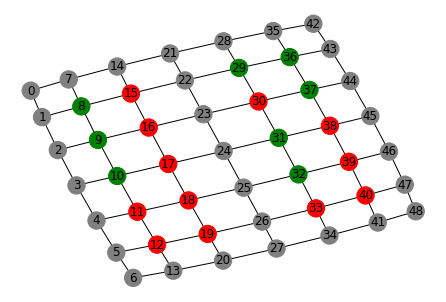

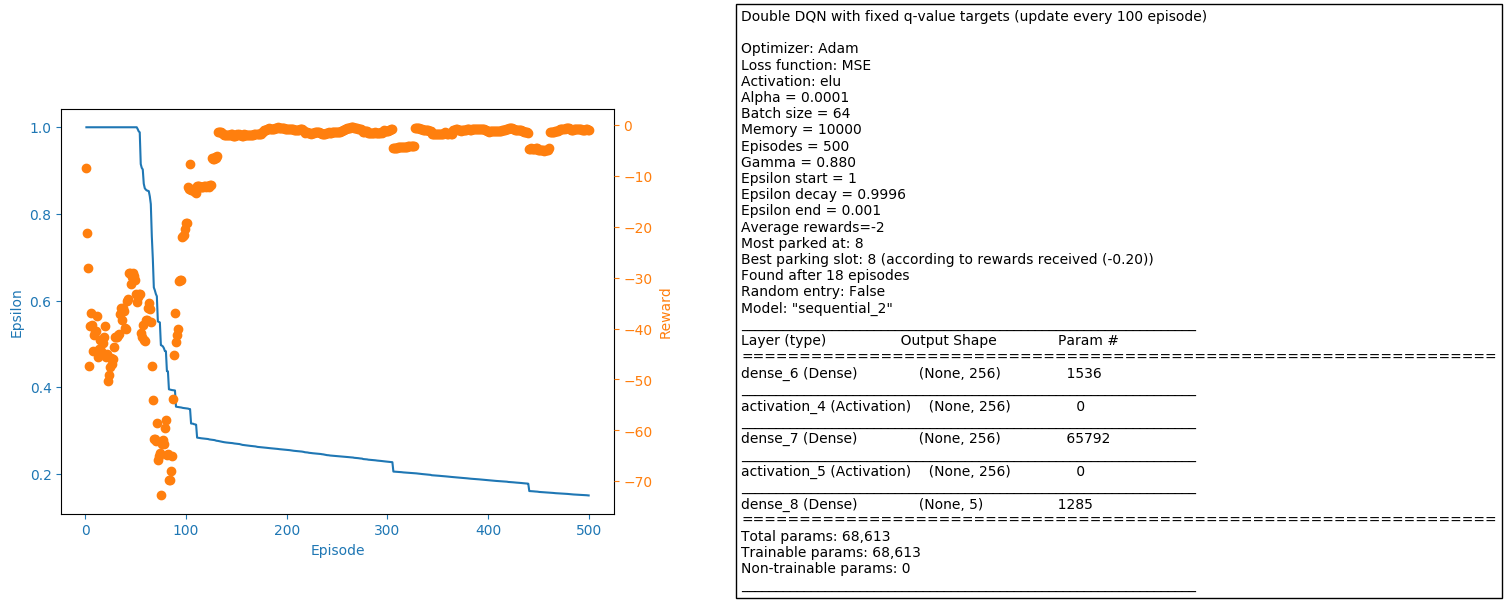

In [0]:
import numpy as np
import time
from collections import Counter
timestr = time.strftime("%Y%m%d-%H%M%S")

def create_env(filling=0.5, nr_slots_per_lane=5, nr_lanes=4, parking_depth=2):
    ffp = Filling_Function_Parameters(uniform_distribution_p_value=filling)
    ldp = Lane_Direction_Parameters()
    parking_environment = Parking_Lot(lane_direction_paramenters=ldp,
                                      filling_function_parameters=ffp,
                                      nr_parking_slots_per_lane=nr_slots_per_lane,
                                      nr_parking_lanes=nr_lanes,
                                      parking_lane_depth=parking_depth,
                                      debug=True,
                                      draw_graph=True,
                                      show_summary=False
                                      )
    return parking_environment


if __name__ == '__main__':
    reward_parameters = Reward_Parameters()
    env = NN_Park_Finder_Agent(reward_parameters=reward_parameters, parking_environment=create_env())

    n_episodes = 500
    learning = True

    replace_target = n_episodes/5
    random_entry = False
    dqn = False
    tpu = False
    agent = Agent(gamma=0.88, epsilon=1.0, alpha=0.0001, input_dims=5,
                  n_actions=5, mem_size=10000, batch_size=64, epsilon_end=0.001,
                  dqn=dqn,tpu=tpu,replace_target=replace_target) 

    #agent.load_models()
    scores = []
    eps_history = []
    found_parking = []
    
    

    for i in range(n_episodes):
        done = False
        score = 0
        observation = env.reset(rand=random_entry)
        entry_point = observation[-1]
        action_history = []
        position_history = []
        # observation = np.array(env.stateSpace)
        for step in range(250):
            action = agent.choose_action(observation)
            # we get back the action which should be taken according to q values
            action_history.append(env.actionNames[action+1])
            # this action might not be possible, so we still have the same observation (because no actual step was made)
            observation_, reward, done, info = env.step(action+1)
            position = env.agentPosition
            #print("observation: {}, action: {}, new observation: {}, agent position: {}".format(observation, env.actionNames[action+1], observation_, position))
            position_history.append(position)
            score += reward
            # we remember in which state what action we took and what the resulting state was with it's reward (might be the same state)
            agent.remember(observation, action, reward, observation_, done)

            observation = observation_
            
            if done:
              break
            
            if i > n_episodes/10 and learning:
              if dqn:
                agent.double_training_step()
              else:
                agent.learn()
        if dqn:
          strategy = 'Double DQN with fixed q-value targets and policy gradient'
          if i % 12 == 0:
            print("updated q targets")
            agent.target.set_weights(agent.q_eval.get_weights())
        if not dqn:
          #if i % replace_target == 0:
            #print("updating target weights")
            #agent.update_network_parameters()
          strategy = 'Double DQN with fixed q-value targets (update every %.0f episode)\n'%(replace_target)


        found_parking.append(position_history[-1])
        eps_history.append(agent.epsilon)
        scores.append(score)

        parking = Counter(found_parking)
         
        avg_score = np.mean(scores[max(0, i-100):(i+1)])
        print('episode', i, 'rewards %.2f' %score, 'average rewards %.2f' %avg_score, 'entry point',entry_point, 'parked on', position_history[-1], 'epsilon %.2f' %agent.epsilon, 'steps', step)
        #print('\n')
        print('positions ',position_history, 'actions ',action_history)
        print('________________________________________________________________________________________')

        if i % 10 == 0 and i > 0:
            agent.save_models()
    stringlist = []
    agent.q_eval.summary(print_fn=lambda x: stringlist.append(x))
    short_model_summary = "\n".join(stringlist)
    max_reward_index = scores.index(max(scores))
    max_reward_position = found_parking[max_reward_index]
    info_data = [strategy, agent.alpha, agent.batch_size, agent.mem_size, 
                 n_episodes, avg_score, parking.most_common(1)[0][0], 
                 max_reward_index, max_reward_position, short_model_summary, 
                 max(scores), random_entry, agent.gamma, agent.epsilon_dec, agent.epsilon_min]

    filename = '/content/drive/My Drive/DQN/'+timestr+'_dqn.png'
    x = [i+1 for i in range(n_episodes)]
    plotLearning(x, scores, eps_history, filename, info_data)

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()